# Image-captioning-with-Attention

In [1]:
#imports 
import os
import numpy as np
from collections import Counter
import spacy
import pandas as pd
from PIL import Image
import typing
from typing import List

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
from torch import optim
from torch.nn import functional
from torchvision import transforms
from torchvision import models

## Data preparation

In [2]:
data_location =  "../input/flickr8k"

In [3]:
#reading the text data 
import pandas as pd
captions_file = data_location + '/captions.txt'
captions_df = pd.read_csv(captions_file)
print(f"There are {len(captions_df)} image to captions")
captions_df.head(7)

There are 40455 image to captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


In [4]:
# First, let's get unique image IDs
unique_image_ids = captions_df['image'].unique()

# Sort the unique image IDs
sorted_image_ids = sorted(unique_image_ids)

# Calculate the index to split the data
split_index = int(len(sorted_image_ids) * 0.8)  # 80-20 split

# Split the sorted image IDs into train and test sets
train_image_ids = sorted_image_ids[:split_index]
test_image_ids = sorted_image_ids[split_index:]

# Now filter the DataFrame based on train and test image IDs
train_df = captions_df[captions_df['image'].isin(train_image_ids)]
test_df = captions_df[captions_df['image'].isin(test_image_ids)]

# Ensure no image is in both train and test sets
assert len(set(train_df['image'].unique()).intersection(set(test_df['image'].unique()))) == 0

# Now train_df and test_df contain the split data
# captions_df

## Building Vocabulary

In [5]:
class Vocabulary:
    #using spacy for text tokenization 
    spacy_eng = spacy.load("en_core_web_sm")

    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.index_to_str = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        self.str_to_index = {v:k for k,v in self.index_to_str.items()}
        
        #threshold for unkown words
        self.freq_threshold = freq_threshold
        
    def __len__(self): 
        return len(self.index_to_str)
    
    def build_vocab(self, sentence_list:List):
        tocken_frequencies = Counter()
        tocken_index = 4 # because 0->3 are already defined
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                tocken_frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if tocken_frequencies[word] == self.freq_threshold:
                    self.str_to_index[word] = tocken_index
                    self.index_to_str[tocken_index] = word
                    tocken_index += 1
    
    def sentence_to_indices(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.str_to_index[token] if token in self.str_to_index else self.str_to_index["<UNK>"] for token in tokenized_text ]  
    
    def indices_to_sentence(indices, index_to_str):
        """ Convert a list of indices back to a sentence using a provided index_to_str mapping """
        return ' '.join([index_to_str[index] for index in indices])
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]

In [6]:
#testing the vicab class 
v = Vocabulary(freq_threshold=1)

v.build_vocab(["This is a good place to find a city"])
print(v.str_to_index)
print(v.sentence_to_indices("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3]


## Building Dataset

In [7]:
class FlickrDataset(Dataset):
    """
    FlickrDataset object for easy manipulation
    """
    def __init__(self,images_dir,captions_df,transform=None,freq_threshold=5):
        self.images_dir = images_dir #root directory of flickr that contains the images folder
        self.captions_df = captions_df
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.captions_df["image"]
        self.captions = self.captions_df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.captions_df)
    
    def __getitem__(self,index):
        caption = self.captions[index]
        img_name = self.imgs[index]
        img_location = os.path.join(self.images_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #sentence_to_indices the caption text
        caption_vec = []
        caption_vec += [self.vocab.str_to_index["<SOS>"]]
        caption_vec += self.vocab.sentence_to_indices(caption)
        caption_vec += [self.vocab.str_to_index["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [8]:
class Image_Captions_Collate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,padding_tocken_idx,batch_first=False):
        self.padding_tocken_idx = padding_tocken_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.padding_tocken_idx)
        return imgs,targets

In [9]:
#setting the constants
data_location =  "../input/flickr8k"


#defining the transform to be applied
images_transforms = transforms.Compose([
    transforms.Resize(226),                     
    transforms.RandomCrop(224),                 
    transforms.ToTensor(),                               
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])


#testing the dataset class
train_dataset =  FlickrDataset(
    images_dir = data_location+"/Images",
    captions_df = train_df,
    transform = images_transforms
)

In [10]:
pad_idx = train_dataset.vocab.str_to_index["<PAD>"]

#setting the constants
BATCH_SIZE = 100
NUM_WORKER = 4

#writing the dataloader
data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    # batch_first=False
    collate_fn=Image_Captions_Collate(padding_tocken_idx=pad_idx,batch_first=True)

)

## Encoder

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features


## Attention

In [12]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.decoder_attention = nn.Linear(decoder_dim,attention_dim)
        self.encoder_attention = nn.Linear(encoder_dim,attention_dim)
        
        self.attention_layer = nn.Linear(attention_dim,1)
        
          
        
        
    def forward(self, features, hidden_state):
        encoder_attention_states = self.encoder_attention(features)     #(batch_size,num_layers,attention_dim)
        decoder_attention_states = self.decoder_attention(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(encoder_attention_states + decoder_attention_states.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.attention_layer(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = functional.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

## Decoder

In [13]:
#Attention Decoder
class DecoderLSTM(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        
        self.logits_layer = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.logits_layer(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.str_to_index['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.logits_layer(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.index_to_str[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.index_to_str[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,image_transformation,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderLSTM(
            embed_size=embed_size,
            vocab_size = vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        self.image_transformation=image_transformation
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs
    
    #generate caption
    def get_caps_from_image(self,image,show_image=False):
        features_tensors = self.image_transformation(image).unsqueeze(0)
        #generate the caption
        model.eval()
        with torch.no_grad():
            features = self.encoder(features_tensors.to(device))
            caps,alphas = self.decoder.generate_caption(features,vocab=train_dataset.vocab)
            caption = ' '.join(caps)
            if show_image:
                show_image(features_tensors[0],title=caption)
        return caption,caps,alphas
        
        
    def save_model(self,model,num_epochs):
        model_state = {
            'num_epochs':num_epochs,
            'embed_size':embed_size,
            'vocab_size':vocab_size,
            'attention_dim':attention_dim,
            'encoder_dim':encoder_dim,
            'decoder_dim':decoder_dim,
            'state_dict':model.state_dict()
        }

        torch.save(model_state,f'attention_model_state_{num_epochs}.pth')
    
    @staticmethod
    def load_model(path):
        # Define the path to your saved model state dictionary
        model_state_path = path

        # Load the state dictionary
        model_state = torch.load(model_state_path,map_location=torch.device('cpu'))

        # Initialize your model architecture
        model = EncoderDecoder(
            embed_size=model_state['embed_size'],
            vocab_size=model_state['vocab_size'],
            attention_dim=model_state['attention_dim'],
            encoder_dim=model_state['encoder_dim'],
            decoder_dim=model_state['decoder_dim']
        )

        # Load the state dictionary into the model
        model.load_state_dict(model_state['state_dict'])

        # If the model was trained on GPU and you want to use it on GPU
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Ensure the model is in evaluation mode
        model.eval()
        return model


In [15]:
len(train_dataset.vocab)

2673

In [16]:
#init model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 3e-4
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512

model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    image_transformation=images_transforms
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.str_to_index["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [17]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,f'attention_model_state_{num_epochs}.pth')

In [18]:
num_epochs = 200
print_every = 50


for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=train_dataset.vocab)
                caption = ' '.join(caps)
#                 show_image(img[0],title=caption)
            print(caption)
            model.train()
    if epoch % 5 ==0 :
        #save the latest model
        save_model(model,epoch)

Epoch: 1 loss: 4.70502
a man a in a a a . <EOS>
Epoch: 1 loss: 4.38993
a man in a <UNK> in a <UNK> . <EOS>
Epoch: 1 loss: 4.15917
a man in a red in a red . <EOS>
Epoch: 1 loss: 3.94359
a dog is running in the water . <EOS>
Epoch: 1 loss: 3.73482
a man in a blue shirt is standing on a <UNK> . <EOS>
Epoch: 1 loss: 3.47549
a dog is running through the grass . <EOS>
Epoch: 2 loss: 3.47625
a man in a red shirt is standing on a <UNK> . <EOS>
Epoch: 2 loss: 3.43443
a man is standing on a snow . <EOS>
Epoch: 2 loss: 3.32312
a brown dog is running through the snow . <EOS>
Epoch: 2 loss: 3.25151
a woman in a red shirt is standing on a <UNK> . <EOS>
Epoch: 2 loss: 3.14168
a man in a red shirt is riding a bike on a bike . <EOS>
Epoch: 2 loss: 3.11912
a man in a red shirt is standing on a <UNK> . <EOS>
Epoch: 3 loss: 3.01538
a black and white dog is running through the water . <EOS>
Epoch: 3 loss: 3.02813
a man in a red shirt is jumping over a <UNK> . <EOS>
Epoch: 3 loss: 3.03589
a man is jumping o

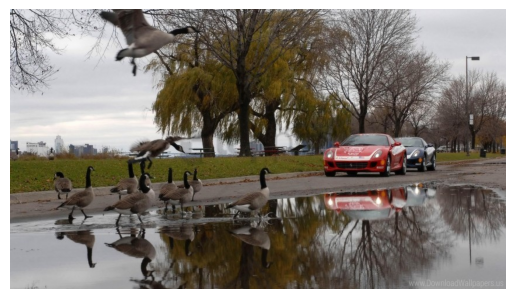

In [19]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# URL of the image you want to download from Google Images
image_url = "https://toppng.com/uploads/preview/birds-cars-nature-pool-road-wallpaper-11556236672boim4gbcsv.jpg"  # Replace this with the actual URL

# Send a GET request to the image URL
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL
    image = Image.open(BytesIO(response.content)).convert("RGB")
    
    # Display the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()
else:
    print("Failed to download the image. Status code:", response.status_code)


In [20]:
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Load existing model

In [21]:
# import torch

# # Define the path to your saved model state dictionary
# model_state_path = "/kaggle/input/image-captioning-with-attention-models-by-epoch/attention_model_state_200.pth"
# model=EncoderDecoder.load_model(model_state_path)


## Test the model

In [22]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu_score(reference_captions, generated_captions, ngram_order=4):
    smoothie = SmoothingFunction().method1  # Define smoothing function
    return corpus_bleu([[ref] for ref in reference_captions], generated_captions, weights=(1.0/ngram_order,)*ngram_order, smoothing_function=smoothie)

def get_reference_captions(test_image_ids, captions_df):
    reference_captions = []
    for img_id in test_image_ids:
        # Get captions for the current image ID
        captions_for_img = captions_df[captions_df['image'] == img_id]['caption'].tolist()
        reference_captions.append(captions_for_img)
    return reference_captions

def test_model_on_test_set(model, test_image_ids, captions_df,images_dir, vocab):
    all_generated_captions = []
    for img_id in test_image_ids:
        # Get captions for the current image ID
        captions_for_img = captions_df[captions_df['image'] == img_id]['caption'].tolist()
        # Load the image
        img_location = os.path.join(images_dir, img_id)
        img = Image.open(img_location).convert("RGB")
        # Generate caption
        caption, _, _ = model.get_caps_from_image(img)
        all_generated_captions.append(caption.split())
    return all_generated_captions



In [23]:
# Get unique test image IDs
test_image_ids = test_df['image'].unique()

# Test model on the test set
generated_captions = test_model_on_test_set(model, test_image_ids, captions_df,data_location+"/Images" ,train_dataset.vocab)

# Get reference captions for the test set
reference_captions = get_reference_captions(test_image_ids, captions_df)


In [24]:
# Calculate BLEU-1 score
bleu1_score = calculate_bleu_score(reference_captions, generated_captions, ngram_order=1)
print("BLEU-1 score:", bleu1_score)

# Calculate BLEU-2 score
bleu2_score = calculate_bleu_score(reference_captions, generated_captions, ngram_order=2)
print("BLEU-2 score:", bleu2_score)

# Calculate BLEU-3 score
bleu3_score = calculate_bleu_score(reference_captions, generated_captions, ngram_order=3)
print("BLEU-3 score:", bleu3_score)

# Calculate BLEU-4 score
bleu4_score = calculate_bleu_score(reference_captions, generated_captions, ngram_order=4)
print("BLEU-4 score:", bleu4_score)


BLEU-1 score: 4.307003187182358e-05
BLEU-2 score: 1.412117302255253e-05
BLEU-3 score: 9.993447952463779e-06
BLEU-4 score: 8.586426042177007e-06
